In [1]:
import numpy as np
import pickle
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

## Data functions

In [2]:
def load_input_data(input_data):
    """
    Return input data as numpy array of [x-coordinate, y-coordinate]
    """
    
    # parse the input
    lines = input_data.split('\n')

    num_nodes = int(lines[0])

    nodes_array = np.zeros((num_nodes, 2))
    for i in range(num_nodes):
        line = lines[i+1]
        parts = line.split()
        nodes_array[i,:] = np.array([float(parts[0]), float(parts[1])])
        
    return nodes_array, num_nodes


In [195]:
# 33810
input_file = open('data/tsp_1889_1','r').read()

In [196]:
nodes_array, num_nodes = load_input_data(input_file)
nodes_array

array([[12784., 10098.],
       [18704.,  8580.],
       [18704., 14234.],
       ...,
       [ 8304.,  6490.],
       [ 8304.,  7040.],
       [12784.,  4840.]])

In [6]:
def prepare_output_data(solution_dict, is_provably_optimal=False):
    """
    Return output in specified format.
    """

    if is_provably_optimal:
        optimal = str(1)
    else:
        optimal = str(0)

    output_data = str(solution_dict['tour_distance']) + ' ' + optimal + '\n'
    output_data += ' '.join(map(str, solution_dict['solution_array']))

    return output_data

In [118]:
prepare_output_data(solution_dict)

'34169.21045841982 0\n181 177 108 37 23 17 115 162 87 15 21 93 150 143 52 165 78 136 83 128 9 117 148 89 48 5 192 62 103 0 159 27 92 57 176 179 60 24 80 101 134 68 167 129 188 140 158 102 172 88 168 41 30 79 55 199 132 144 96 180 196 3 64 65 195 25 186 151 110 183 147 69 18 191 109 74 198 118 113 91 7 156 135 173 66 50 86 105 8 6 56 146 130 166 61 163 119 154 141 34 85 26 11 19 54 82 121 33 107 174 153 161 182 171 29 170 137 127 138 47 187 197 13 2 45 28 42 189 133 124 116 157 70 40 99 155 51 77 95 104 4 142 36 185 38 149 84 67 72 122 43 169 175 190 49 193 194 81 94 12 32 75 1 120 39 63 53 164 76 112 178 59 114 22 97 90 126 184 44 31 100 152 14 16 10 139 46 111 145 71 20 73 58 123 131 35 160 125 98 106'

## Distance matrix functions

In [ ]:
## consider sklearn.neighbors.KDTree in future to get k nearest neighbours in O(n log n) 
## rather than the O(n^2) distance matrix

In [7]:
def make_distance_matrix(nodes_array):
    
    return squareform(pdist(nodes_array, 'euclidean'))

In [197]:
distance_matrix = make_distance_matrix(nodes_array)
distance_matrix

array([[    0.        ,  6111.52386889,  7221.69619965, ...,
         5752.22252699,  5424.18325649,  5258.        ],
       [ 6111.52386889,     0.        ,  5654.        , ...,
        10607.9262818 , 10513.40097209,  7002.42815029],
       [ 7221.69619965,  5654.        ,     0.        , ...,
        12966.47739365, 12645.69634303, 11103.76674827],
       ...,
       [ 5752.22252699, 10607.9262818 , 12966.47739365, ...,
            0.        ,   550.        ,  4774.19103095],
       [ 5424.18325649, 10513.40097209, 12645.69634303, ...,
          550.        ,     0.        ,  4991.03195742],
       [ 5258.        ,  7002.42815029, 11103.76674827, ...,
         4774.19103095,  4991.03195742,     0.        ]])

## KD tree functions

A KD tree can give us the k nearest neighbours in O(n log n) time rather than O(n^2), very useful for large problems.

In [9]:
def make_kd_tree(nodes_array):
    
    return cKDTree(nodes_array)

In [10]:
kd_tree = make_kd_tree(nodes_array)

In [58]:
%timeit kd_tree.query(nodes_array[0],k=2,p=2)

122 µs ± 1.44 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [63]:
kd_tree.query(nodes_array[0],k=2,p=2)

(array([   0., 2000.]), array([    0, 33800]))

In [59]:
%timeit distance_matrix[5304,7084]

334 ns ± 6.45 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


## Route traversing functions

Can be done with either a distance matrix or a kd-tree

In [11]:
def traverse_route_dist_mat(route_array, distance_matrix):
    
    first_index = route_array
    second_index = np.concatenate((route_array[1:],  np.array([route_array[0]])))
        
    return sum(distance_matrix[first_index, second_index])

In [14]:
traverse_route_dist_mat(solution_array, distance_matrix)

36861.3862594383

In [60]:
#def traverse_route_kd_tree(route_array, kd_tree):

## Nearest point with randomisation greedy algorithm

In [12]:
def greedy_tour(distance_matrix, num_nodes, start_node_index = None, 
                second_best_greedy_probability = 0):
    
    # copy distance matrix
    function_distance_matrix = np.copy(distance_matrix)
    
    # get max from distance matrix + 1
    max_distance_p1 = np.max(function_distance_matrix) + 1
    
    # initialise solution array
    solution = []
    
    # if start_node_index isn't given pick one randomly
    if start_node_index is None:
        start_node_index = np.random.randint(num_nodes)
        
    # initialise current node and append it to the solution
    node_index = start_node_index
    solution.append(node_index)
    
    # loop until we have no unused indexes left
    while len(solution) < num_nodes:
        
        # put the used indexes values (the column) up to the max + 1 so we don't visit nodes already visited
        function_distance_matrix[:, node_index].fill(max_distance_p1)
        
        # choose the next index based on shortest distance to next node, occasionally taking second 
        # closest with probability second_best_greedy_probability
        min_indexes = np.argpartition(function_distance_matrix[node_index, :], 2)[:2]
        min_indexes_sorted = min_indexes[np.argsort(function_distance_matrix[node_index, :][min_indexes])]       
        if np.random.rand() < second_best_greedy_probability and len(solution) < num_nodes - 2:
            next_index = min_indexes_sorted[1]
        else: 
            next_index = min_indexes_sorted[0]

        # append the index to the solution
        solution.append(next_index)
        
        # set the node index to next index
        node_index = next_index

    return np.array(solution)

In [13]:
solution_array = greedy_tour(distance_matrix, num_nodes, start_node_index = 0, 
                             second_best_greedy_probability = 0.000)
solution_array

array([ 0, 33,  5,  2, 28, 45,  9, 10,  3, 46, 24, 34, 23, 12, 36,  6, 26,
       47, 27, 41,  8,  4, 35, 13,  7, 19, 40, 18, 11, 42, 29, 43, 21, 37,
       20, 25,  1, 22, 31, 39, 50, 38, 15, 44, 16, 14, 30, 48, 32, 17, 49],
      dtype=int64)

In [17]:
def get_nearest_neighbour_not_in_array(node_array, node_index, kd_tree, array, k=10, ith_nearest=1):

    indexes_array = np.array([])
    
    while len(indexes_array) < ith_nearest:
        kd_output = kd_tree.query(node_array[node_index], k=k, p=2)
        indexes_mask = (~np.isin(kd_output[1], array))
        indexes_array = np.arange(k)[indexes_mask]
        k *= 2
        
    return kd_output[1][indexes_array[ith_nearest-1]]

In [74]:
get_nearest_neighbour_not_in_array(nodes_array, 8, kd_tree, np.array([0,8]), k=10, ith_nearest=1)

18

In [16]:
def greedy_tour_kd(kd_tree, node_array, num_nodes, start_node_index = None, 
                   second_best_greedy_probability = 0):
    
    # initialise solution array
    solution_array = np.empty([num_nodes])
    
    # if start_node_index isn't given pick one randomly
    if start_node_index is None:
        start_node_index = np.random.randint(num_nodes)
        
    # initialise current node and append it to the solution
    node_index = start_node_index
    solution_array[0] = node_index
    
    #distance = 0
    
    k = 5
    
    # loop until we have no unused indexes left
    for counter in range(1, num_nodes):
        
        if second_best_greedy_probability == 0: 
            next_node_index = get_nearest_neighbour_not_in_array(node_array, node_index, kd_tree, 
                                                                 solution_array, k=k, ith_nearest=1)
        else:
            if np.random.rand() < second_best_greedy_probability:
                next_node_index = get_nearest_neighbour_not_in_array(node_array, node_index, kd_tree, 
                                                                     solution_array, k=k, ith_nearest=2)
            else:
                 next_node_index = get_nearest_neighbour_not_in_array(node_array, node_index, kd_tree, 
                                                                 solution_array, k=k, ith_nearest=1)
            
        solution_array[counter] = next_node_index
        #distance += next_dist

        # set the node index to next index
        node_index = next_node_index
    

    return solution_array.astype(int)

In [44]:
%time greedy_tour_kd(kd_tree, nodes_array, num_nodes, start_node_index = 0)

Wall time: 1min 38s


array([0.0000e+00, 8.0000e+00, 7.0000e+00, ..., 1.6982e+04, 1.7340e+04,
       1.7334e+04])

In [48]:
kd_tree.query(nodes_array[8], k=10, p=2)

(array([   0.        , 2000.        , 2000.        , 2000.        ,
        2113.2025459 , 2828.42712475, 2828.42712475, 4000.        ,
        4000.        , 4000.        ]),
 array([    8,     0,    18,     7,  1316, 33809,    17,     6,    28,
        33800]))

In [24]:
#s = greedy_tour_kd(kd_tree, nodes_array, num_nodes, start_node_index = 0)
#s

In [15]:
def get_best_greedy_tour(distance_matrix, num_nodes, num_runs = 100,
                         start_node_index = None, 
                         second_best_greedy_probability = 0):
    
    best_solution = greedy_tour(distance_matrix, num_nodes, start_node_index = start_node_index, 
                                second_best_greedy_probability = second_best_greedy_probability)
    best_distance = traverse_route_dist_mat(best_solution, distance_matrix)
    
    for run in range(num_runs-1):
        solution = greedy_tour(distance_matrix, num_nodes, start_node_index = start_node_index, 
                               second_best_greedy_probability = second_best_greedy_probability)
        distance = traverse_route_dist_mat(solution, distance_matrix)
        if distance < best_distance:
            best_solution = solution
            best_distance = distance
            
    solution_dict = {
        'solution_array': best_solution,
        'tour_distance': best_distance
    }
            
    return solution_dict

In [17]:
solution_dict = get_best_greedy_tour(distance_matrix, num_nodes, num_runs = 1000,
                                     start_node_index = None, 
                                     second_best_greedy_probability = 0.005)
solution_dict

{'solution_array': array([48, 32,  0, 33,  5,  2, 28, 45,  9, 10,  3, 46, 24, 34, 23, 12, 36,
         6, 26, 47, 27, 41,  8,  4, 35, 13,  7, 19, 40, 18, 11, 42, 29, 43,
        21, 37, 20, 25,  1, 22, 31, 39, 50, 38, 15, 44, 14, 16, 30, 49, 17],
       dtype=int64), 'tour_distance': 483.6432028945665}

In [202]:
def solve_it_greedy(distance_matrix, num_nodes, num_runs=100):

    solution_dict = get_best_greedy_tour(distance_matrix, num_nodes, num_runs=num_runs)

    return solution_dict

## 2-opt

In [173]:
def calculate_gain(tour, distance_matrix, node_1_index, node_2_index):
    
    num_nodes = distance_matrix.shape[0]
    
    return distance_matrix[tour[node_1_index], tour[(node_1_index+1)%num_nodes]] \
            + distance_matrix[tour[node_2_index%num_nodes], tour[(node_2_index+1)%num_nodes]] \
            - distance_matrix[tour[node_1_index], tour[node_2_index%num_nodes]] \
            - distance_matrix[tour[(node_1_index+1)%num_nodes], tour[(node_2_index+1)%num_nodes]] \
          

In [152]:
for n1 in range(51-3):
    for n2 in range(n1+2, 50):
        gain = calculate_gain(solution_dict['solution_array'], distance_matrix, n1, n2)
        if gain < 0:
            print(n1)
            print(n2)
            print(gain)

22
37
-7.689699350699705
30
37
-1.611660643851657
31
37
-1.7909360344945924
32
37
-0.022074226255305973
33
37
-1.474607132604831
35
37
-0.04568434508610153
38
40
-3.0234963036976996
45
49
-1.3672993674253
46
49
-4.880680568834819


In [114]:
def swap_tour_edges(tour, node_1_index, node_2_index):

    return np.concatenate((tour[:node_1_index+1], np.array([tour[node_2_index]]), 
                            np.flip(tour[node_1_index+2:node_2_index]), np.array([tour[node_1_index+1]]),
                            tour[node_2_index+1:]))

In [129]:
swap_tour_edges(np.array(['a','b','c','d','h','g','f','e']), 3,7)

array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'], dtype='<U1')

In [113]:
tour = np.array(['b','c','d','h','g','f','e','a'])
node_1_index = 2
node_2_index = 6
print(tour[:node_1_index+1])
print(np.array([tour[node_2_index]]))
print(np.flip(tour[node_1_index+2:node_2_index]))
print(np.array([tour[node_1_index+1]]))
print(tour[node_2_index+1:])
#swap_tour_edges(np.array(['b','c','d','h','g','f','e','a']), 3, 7)

['b' 'c' 'd']
['e']
['f' 'g']
['h']
['a']


In [179]:
def two_opt(solution_dict, distance_matrix, num_runs=1000):
    
    tour = solution_dict['solution_array']
    best_distance = solution_dict['tour_distance']
    size = len(tour)
    improved = True
    
    counter = 0
    
    while improved:
        if counter > num_runs:
            break
        improved = False
        for n1 in range(size-3):
            for n2 in range(n1+2, size):
                gain = calculate_gain(tour, distance_matrix, n1, n2)
                if gain > 0:
                    best_distance -= gain
                    tour = swap_tour_edges(tour, n1, n2)
                    improved = True
                    counter += 1
        
    solution_dict = {
        'solution_array': tour,
        'tour_distance': best_distance
    }
            
    return solution_dict

### idea - search only k nearest neighbours for swap, rather than all unseen indicies - should have a speedup

In [198]:
solution_dict = get_best_greedy_tour(distance_matrix, num_nodes, num_runs = 100,
                                     start_node_index = None, 
                                     second_best_greedy_probability = 0.005)
solution_dict

{'solution_array': array([ 357,  404,  869, ..., 1568, 1569, 1570], dtype=int64),
 'tour_distance': 378128.0214049315}

In [200]:
solution_dict = two_opt(solution_dict, distance_matrix)
solution_dict

{'solution_array': array([357, 404, 869, ..., 632, 765, 536], dtype=int64),
 'tour_distance': 344083.5675083665}

In [203]:
def solve_it_two_opt(distance_matrix, num_nodes, num_runs_greedy, num_runs_two_opt):
    
    solution_dict = get_best_greedy_tour(distance_matrix, num_nodes, num_runs = num_runs_greedy,
                                         start_node_index = None, 
                                         second_best_greedy_probability = 0.005)
    
    solution_dict = two_opt(solution_dict, distance_matrix, num_runs=num_runs_greedy)
    
    return solution_dict

## Visualise solution

In [18]:
def plot_tour(nodes_array, distance_matrix, solution_dict):
    
    solution_array = solution_dict['solution_array']
    distance = solution_dict['tour_distance']
    
    num_nodes = nodes_array.shape[0]
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Optimized tour')
    ax.scatter(nodes_array[:, 0], nodes_array[:, 1])
    start_node = solution_array[0]
    #distance = 0.
    for i in range(num_nodes):
        start_pos = nodes_array[start_node]
        next_node = solution_array[i] 
        end_pos = nodes_array[next_node]
        ax.annotate("",
                xy=start_pos, xycoords='data',
                xytext=end_pos, textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))
        #distance += distance_matrix[start_node, next_node] 
        start_node = next_node
        
    ax.annotate("",
                xy=end_pos, xycoords='data',
                xytext=nodes_array[solution_array[0]], textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))
    #distance += distance_matrix[next_node, solution_array[0]]

    textstr = "N nodes: %d\nTotal length: %.3f" % (num_nodes, distance)
    plt.title(textstr)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    plt.tight_layout()
    plt.show()

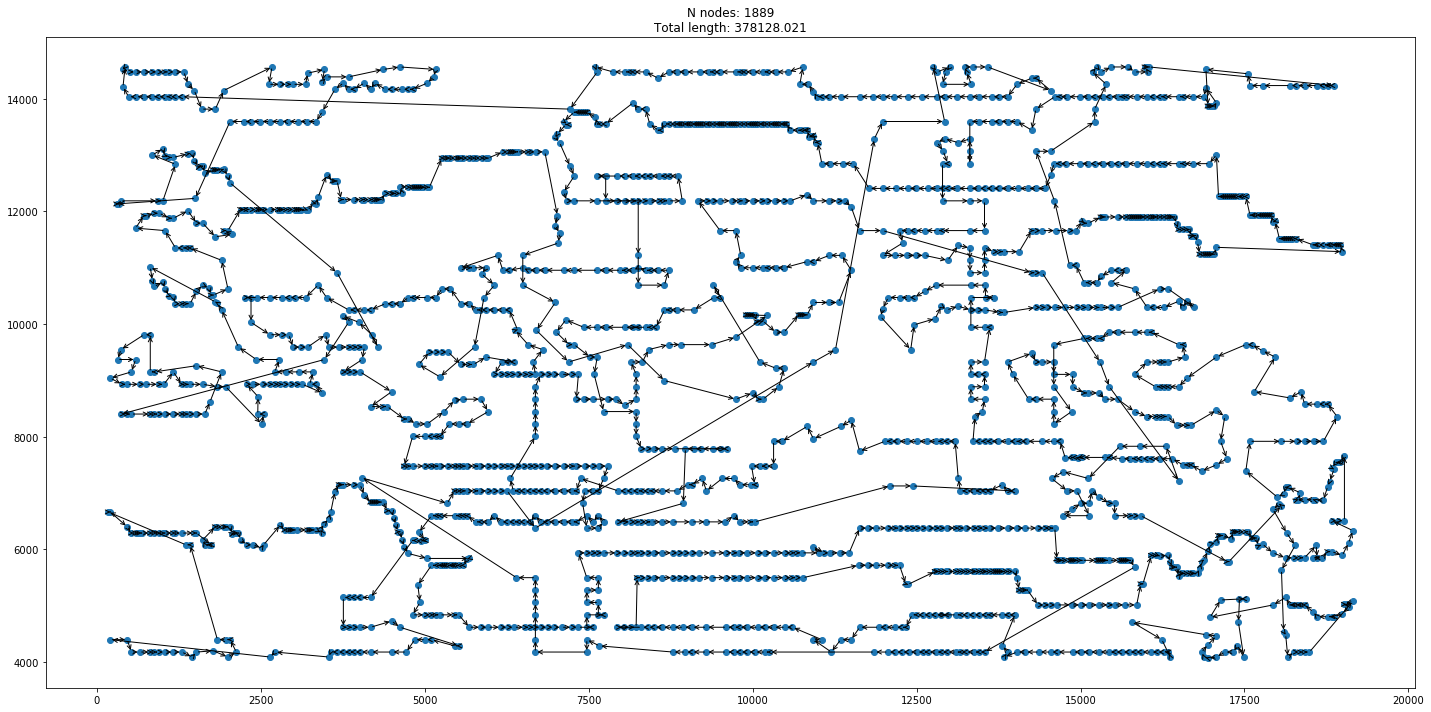

In [199]:
plot_tour(nodes_array, distance_matrix, solution_dict)

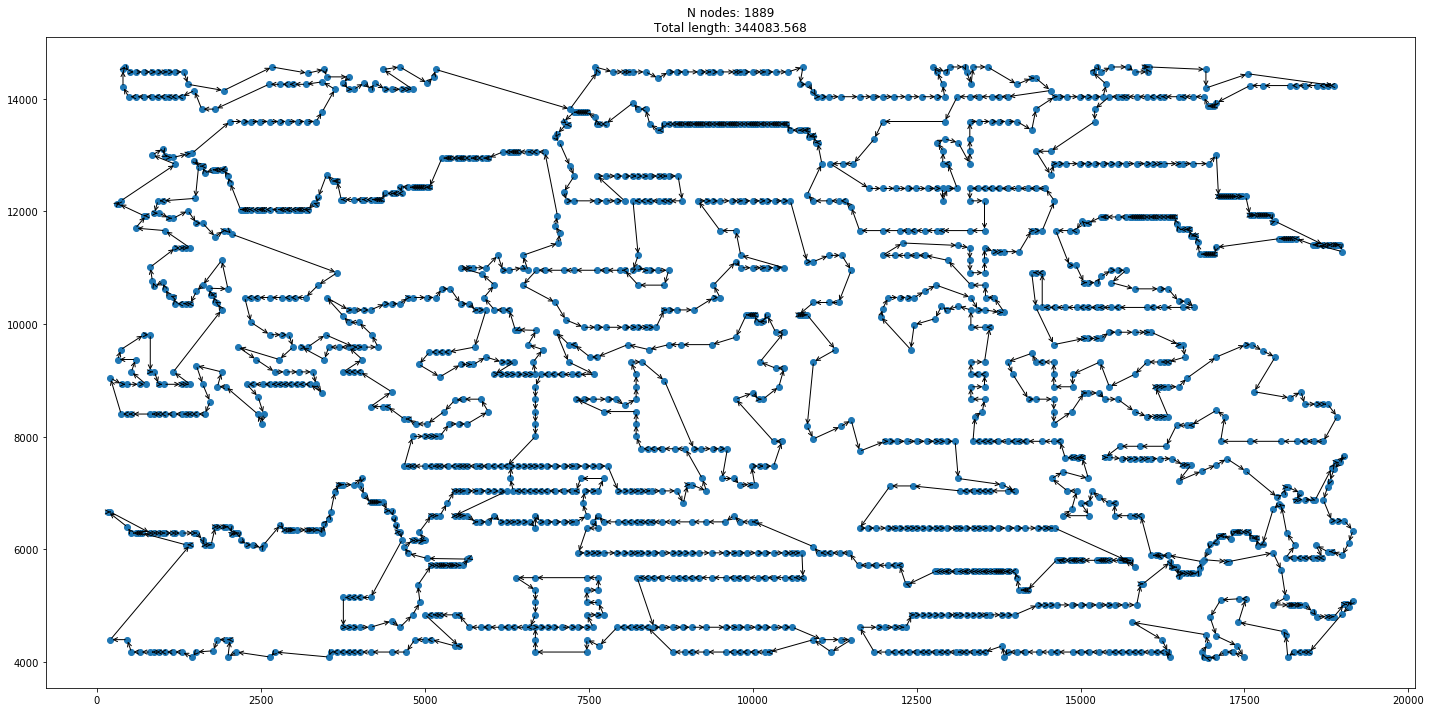

In [201]:
plot_tour(nodes_array, distance_matrix, solution_dict)